# Meteorite Impacts

NASA has helpfully provided a dataset which lists recorded meteorite impacts - get it in `"Meteorite_Landings.csv"`. Can we utilise this dataset to predict the chance that, within 1000 years, a high-impact meteor will strike the planet?

Let's define high-impact as an asteroid greater than 1km in diameter. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("Meteorite_Landings.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45716 entries, 0 to 45715
Data columns (total 10 columns):
name           45716 non-null object
id             45716 non-null int64
nametype       45716 non-null object
recclass       45716 non-null object
mass           45585 non-null float64
fall           45716 non-null object
year           45428 non-null float64
reclat         38401 non-null float64
reclong        38401 non-null float64
GeoLocation    38401 non-null object
dtypes: float64(4), int64(1), object(5)
memory usage: 3.5+ MB


In [2]:
df.head()

,name,id,nametype,recclass,mass,fall,year,reclat,reclong,GeoLocation
0,Aachen,1,Valid,L5,21.0,Fell,1880.0,50.77500,6.08333,"(50.775000, 6.083330)"
1,Aarhus,2,Valid,H6,720.0,Fell,1951.0,56.18333,10.23333,"(56.183330, 10.233330)"
2,Abee,6,Valid,EH4,107000.0,Fell,1952.0,54.21667,-113.00000,"(54.216670, -113.000000)"
3,Acapulco,10,Valid,Acapulcoite,1914.0,Fell,1976.0,16.88333,-99.90000,"(16.883330, -99.900000)"
4,Achiras,370,Valid,L6,780.0,Fell,1902.0,-33.16667,-64.95000,"(-33.166670, -64.950000)"


### Investigate and explore Data

Now, from the fact that we have different numbers of non-null objects in the previous info, we should make sure the columns we want to work with all have sensible values.

In [4]:
df2 = df.dropna(subset=["mass", "year"])  # Remove NaN values
df2 = df2[df2["mass"] > 0]  # Zero mass impacts are also missing data

In [5]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45292 entries, 0 to 45715
Data columns (total 10 columns):
name           45292 non-null object
id             45292 non-null int64
nametype       45292 non-null object
recclass       45292 non-null object
mass           45292 non-null float64
fall           45292 non-null object
year           45292 non-null float64
reclat         38097 non-null float64
reclong        38097 non-null float64
GeoLocation    38097 non-null object
dtypes: float64(4), int64(1), object(5)
memory usage: 3.8+ MB


Let's also explore the data visually.

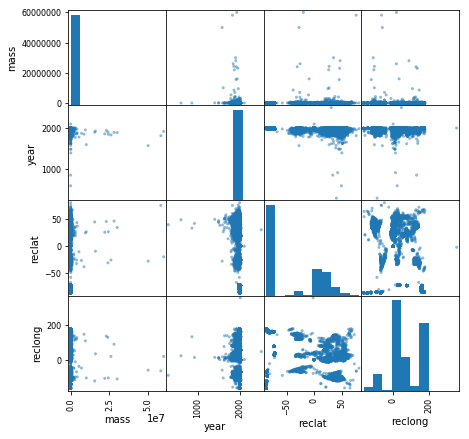

In [6]:
pd.plotting.scatter_matrix(df[["mass", "year", "reclat", "reclong"]], figsize=(7,7));

An important thing to note is we can make out the continents in the scatter. A real analysis would have to look at detection efficiency properly (something like the percentage of meteorites we successfully observe as a function of location on the planet), but we'll just keep in mind that this dataset only captures some meteorites and only in populated areas.

Now, mass is a positive value that spans many orders of magnitude, so it'll probably be easier to look at log mass instead of mass itself.

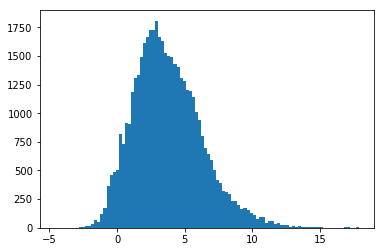

In [7]:
year = df2["year"]
masses = df2["mass"]
logmass = np.log(masses)
plt.hist(logmass, bins=100);

Yup, this is far easier to quantify than the mass distribution. As to the years, obviously there is an issue here - our technology has changed a lot over the last few thousand years, and so our detection efficiency should also take this into account. However, we don't have the data to make that analysis in this dataset. So what we can do is take our peak year as a pseudo-worst case.

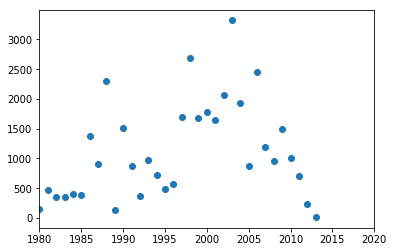

In [8]:
counts = year.value_counts()
plt.scatter(counts.index, counts)
plt.xlim(1980, 2020);

So, lets quantify our log-mass distribution from before. We can start and see if a normal works well.

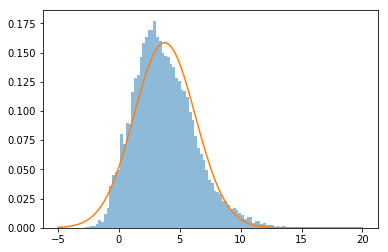

In [11]:
from scipy.stats import norm, skewnorm, lognorm
ms = np.linspace(-5, 20, 100)

mean, std = logmass.mean(), np.std(logmass)
pdf_norm = norm.pdf(ms, mean, std)
plt.hist(logmass, bins=100, density=True, alpha=0.5)
plt.plot(ms, pdf_norm);

Not the best... Lets try both a skew-norm and a log-norm.

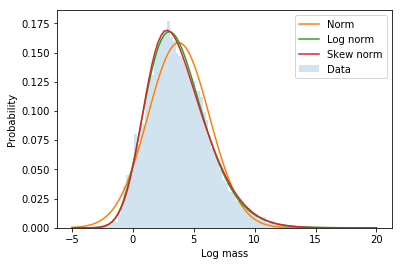

In [12]:
p_lognorm = lognorm.fit(logmass)
pdf_lognorm = lognorm.pdf(ms, *p_lognorm)

p_skewnorm = skewnorm.fit(logmass)
pdf_skewnorm = skewnorm.pdf(ms, *p_skewnorm)

plt.hist(logmass, bins=100, density=True, alpha=0.2, label="Data")
plt.plot(ms, pdf_norm, label="Norm")
plt.plot(ms, pdf_lognorm, label="Log norm")
plt.plot(ms, pdf_skewnorm, label="Skew norm");
plt.legend()
plt.xlabel("Log mass")
plt.ylabel("Probability");

So either the log-norm or skew-norm looks like an adequate fit to the data. We want to extrapolate this distribution out to a mass we're concerned about - the mass of a 1km diameter meteor.

In [13]:
mass_of_doom = np.log((4/3) * np.pi * 500**3 * 1600 * 1000)  # Just using a spherical approximation and some avg density
mass_of_doom

34.36175044077777

So where does this value lie on our distribution. We'll go with the lognorm for now.

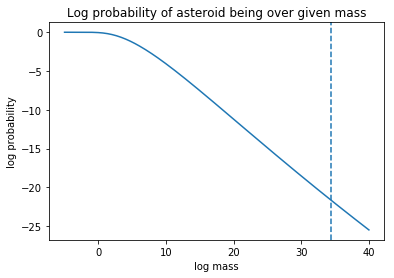

In [14]:
ms2 = np.linspace(-5, 40, 200)
plt.plot(ms2, lognorm.logsf(ms2, *p_lognorm))
plt.axvline(mass_of_doom, ls="--")
plt.xlabel("log mass")
plt.ylabel("log probability")
plt.title("Log probability of asteroid being over given mass");

So we have here the probability of an asteroid being above a certain mass when it hits Earth. But to answer the question "What is the probability that one or more asteroids of high mass strike Earth in 1000 years?" we need to factor in the actual time component. Assume that in the next 1000 years, we predict to have $N$ impacts.

$$P(>=1\  {\rm highmass}) = 1 - P(0\ {\rm highmass}) = 1 - P(N\ {\rm not\_highmass}) = 1 - P({\rm not\_highmass})^N$$

Imagine a similar question: Prob of getting no sixes in 5 rolls. Well its $$\frac{5}{6}\times\frac{5}{6}\times\frac{5}{6}\times\frac{5}{6}\times\frac{5}{6} = \left(\frac{5}{6}\right)^5 $$
The prob of getting one or more sixes is then $1 - (5/6)^5$.

So to give a number, we need to calculate $N$ from the yearly rate, number of years, and our detection efficiency and use that with the probability that any given impact is not high mass.

In [15]:
prob_small_mass = lognorm.logcdf(mass_of_doom, *p_lognorm)
frac_sky_monitored = 0.2
num_years = 1000
num_events = num_years * counts.max() / frac_sky_monitored
prob_bad = 1 - np.exp(num_events * prob_small_mass)
print(f"Prob a >1km asteroid impacts with {num_years} years is {prob_bad * 100:.2f}%")

Prob a >1km asteroid impacts with 1000 years is 0.67%
